<a href="https://colab.research.google.com/github/hparupudi/AircraftDetection/blob/main/AircraftIdentification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn

import torchvision
from torchvision import transforms, datasets

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

import os

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize(size=(256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(256, 256)),
    transforms.ToTensor()
])

train_data = datasets.FGVCAircraft(
    root="data",
    split="train",
    annotation_level="variant",
    transform=train_transform,
    target_transform=None,
    download=True
)

test_data = datasets.FGVCAircraft(
    root="data",
    split="test",
    annotation_level="variant",
    transform=test_transform,
    target_transform=None,
    download=True
)



100%|██████████| 2753340328/2753340328 [02:25<00:00, 18902553.52it/s]


Extracting data/fgvc-aircraft-2013b.tar.gz to data


In [ ]:
index = list(range(0, len(train_data), 16))
train_ds = torch.utils.data.Subset(train_data, index)
test_ds = torch.utils.data.Subset(test_data, index)
len(train_ds), len(test_ds)

(209, 209)

Length of train dataset: 3334


(-0.5, 255.5, 255.5, -0.5)

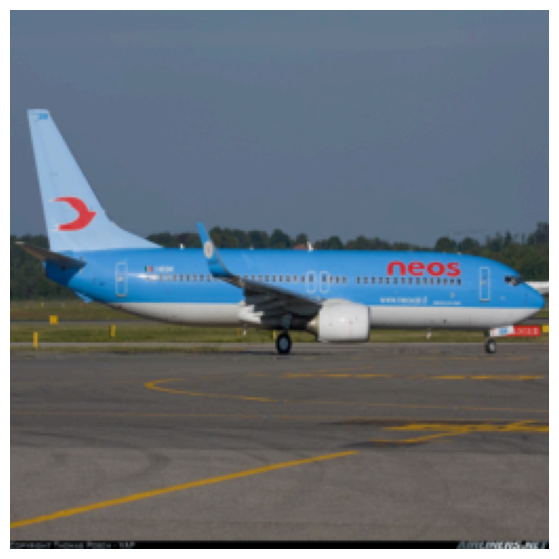

In [ ]:
class_names = train_data.classes
class_idx = train_data.class_to_idx
img, label = train_data[269]

print(f"Length of train dataset: {len(train_data)}")
plt.figure(figsize=(10, 7))
plt.imshow(img.squeeze().permute(1, 2, 0))
plt.axis(False)

In [ ]:
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=32,
                              num_workers=os.cpu_count(),
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=32,
                             num_workers=os.cpu_count(),
                             shuffle=False)

In [ ]:
class AircraftV1(nn.Module):
  def __init__(self, input_shape:int, hidden_units:int, output_shape:int) -> None:
    super().__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
         nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.layer3 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
         nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*64*64,
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.classifier(x)
    return x


In [ ]:
model_0 = AircraftV1(input_shape=3,
                     hidden_units=30,
                     output_shape=len(class_names)).to(device)

train_batch, train_labels = next(iter(train_dataloader))

y_preds = model_0(train_batch.to(device))
len(y_preds)

KeyboardInterrupt: 

In [ ]:
#Setup accuracy function, loss function, optimizer

def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

NameError: name 'model_0' is not defined

In [ ]:
weights = torchvision.models.VGG16_Weights.DEFAULT
auto_transforms = weights.transforms()
model_1 = torchvision.models.vgg16(weights=weights).to(device)

for param in model_1.features.parameters():
  param.requires_grad = False

model_1.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [ ]:
output_shape = len(class_names)
model_1.classifier = torch.nn.Sequential(
    torch.nn.Linear(in_features=25088,
                    out_features=4096,
                    bias=True),
    torch.nn.ReLU(inplace=True),
    torch.nn.Dropout(p=0.5, inplace=False),
    torch.nn.Linear(in_features=4096,
                    out_features=4096,
                    bias=True),
    torch.nn.ReLU(inplace=True),
    torch.nn.Dropout(p=0.5, inplace=False),
    torch.nn.Linear(in_features=4096,
                    out_features=output_shape,
                    bias=True)
).to(device)

In [ ]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

In [ ]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model_2 = torchvision.models.efficientnet_b0(weights=weights).to(device)
model_2.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.5, inplace=True),
    torch.nn.Linear(in_features=1280, out_features=100)
)
model_2.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2.parameters(), lr=0.001)

In [24]:
from tqdm.auto import tqdm

epochs = 10

for epoch in tqdm(range(epochs)):

  if epoch % 1 == 0:
    print(f"Epoch: {epoch} \n")

  model_2.train()
  train_loss, train_acc = 0, 0

  for batch, (X, y) in enumerate(train_dataloader):
    X, y = X.to(device), y.to(device)
    y_pred = model_2(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(train_dataloader)
  train_acc /= len(train_dataloader)

  model_2.eval()
  test_loss, test_acc = 0, 0
  model_2.to(device)

  with torch.inference_mode():
    for batch, (X, y) in enumerate(test_dataloader):
      X, y = X.to(device), y.to(device)
      y_pred = model_2(X)
      loss = loss_fn(y_pred, y)
      test_loss += loss
      test_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

  if epoch % 1 == 0:
    print(f"Train Loss: {train_loss: .5f} | Train Acc: {train_acc: .2f}% | Test Loss: {test_loss: .5f} | Test acc: {test_acc: .2f}%")


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 

Train Loss:  0.42710 | Train Acc:  87.43% | Test Loss:  1.03975 | Test acc:  75.38%
Epoch: 1 

Train Loss:  0.36613 | Train Acc:  89.05% | Test Loss:  1.06631 | Test acc:  74.73%
Epoch: 2 

Train Loss:  0.40404 | Train Acc:  88.08% | Test Loss:  1.08363 | Test acc:  74.93%
Epoch: 3 

Train Loss:  0.43840 | Train Acc:  87.80% | Test Loss:  0.94429 | Test acc:  77.22%
Epoch: 4 

Train Loss:  0.38271 | Train Acc:  88.52% | Test Loss:  1.06609 | Test acc:  76.21%
Epoch: 5 

Train Loss:  0.41282 | Train Acc:  87.68% | Test Loss:  1.03716 | Test acc:  75.70%
Epoch: 6 

Train Loss:  0.35162 | Train Acc:  89.55% | Test Loss:  1.12430 | Test acc:  74.62%
Epoch: 7 

Train Loss:  0.34942 | Train Acc:  90.12% | Test Loss:  1.15256 | Test acc:  74.07%
Epoch: 8 

Train Loss:  0.34268 | Train Acc:  89.54% | Test Loss:  1.11371 | Test acc:  76.03%
Epoch: 9 

Train Loss:  0.38269 | Train Acc:  88.74% | Test Loss:  1.10718 | Test acc:  74.57%


In [16]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [17]:
model_save_name = "model_2.pth"
path = F"/content/gdrive/My Drive/{model_save_name}"
torch.save(model_2.state_dict(), path)

In [18]:
model_save_name = "model_2.pth"
path = F"/content/gdrive/My Drive/{model_save_name}"
model_2.load_state_dict(torch.load(path, map_location=torch.device('cpu')))

<All keys matched successfully>

In [27]:
import random

test_samples = []
test_labels = []
pred_probs = []

for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

model_2.eval()
with torch.inference_mode():
  for sample in test_samples:
    tesample = torch.unsqueeze(sample, dim=0).to(device)
    pred_logit = model_2(tesample.to(device))
    pred_prob = pred_logit.argmax(dim=1)
    pred_probs.append(pred_prob.cpu())

pred_probs = torch.stack(pred_probs)
print(pred_probs)

tensor([[54],
        [73],
        [39],
        [97],
        [74],
        [ 5],
        [19],
        [20],
        [41]])


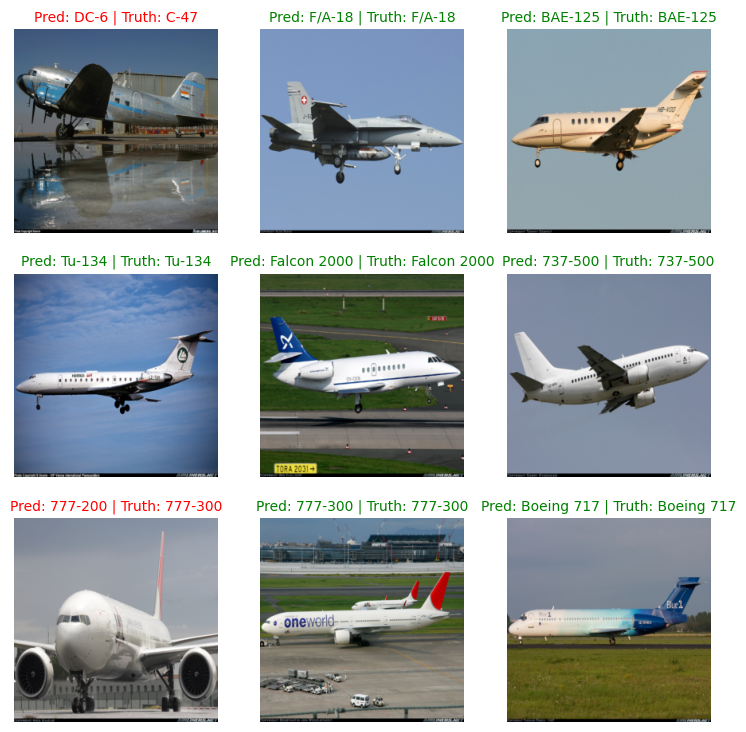

In [28]:
plt.figure(figsize=(9, 9))
rows = 3
cols = 3
for i, sample in enumerate(test_samples):
  plt.subplot(rows, cols, i+1)
  plt.imshow(sample.squeeze().permute(1, 2, 0))
  pred_label = class_names[pred_probs[i]]
  label = class_names[test_labels[i]]
  title_text = f"Pred: {pred_label} | Truth: {label}"

  if pred_label == label:
    plt.title(title_text, fontsize=10, c="g")
  else:
    plt.title(title_text, fontsize=10, c="r")

  plt.axis(False)

(-0.5, 255.5, 255.5, -0.5)

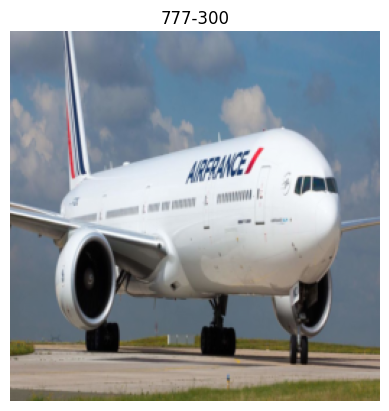

In [30]:
import torchvision
from pathlib import Path

data = Path("data/")
img_path = data / "777-300.jpg"

img_tensor = torchvision.io.read_image(str(img_path)).type(torch.float32) / 255
img_tensor = img_tensor.to(device)

img_transform = transforms.Compose([
    transforms.Resize(size=(256, 256))
])

img_tensor = img_transform(img_tensor)

model_2.to(device)
model_2.eval()
with torch.inference_mode():
  image_pred = model_2(img_tensor.unsqueeze(0)).to(device)
  image_pred = image_pred.argmax(dim=1)

plt.imshow(img_tensor.squeeze().permute(1, 2, 0).to("cpu"))
plt.title(class_names[image_pred])
plt.axis(False)